### Fully Bayesian Unfolding Spectrum From the First Excited state of 28Si

This jupyter file shows how the results from chapter 5, section 1 where obtained. 

In [1]:
import ompy as om 
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as mc
import scipy as sp
from theano import tensor as T
import theano; theano.gof.cc.get_module_cache().clear()
import pandas as pd 
import fbu

<IPython.core.display.Javascript object>


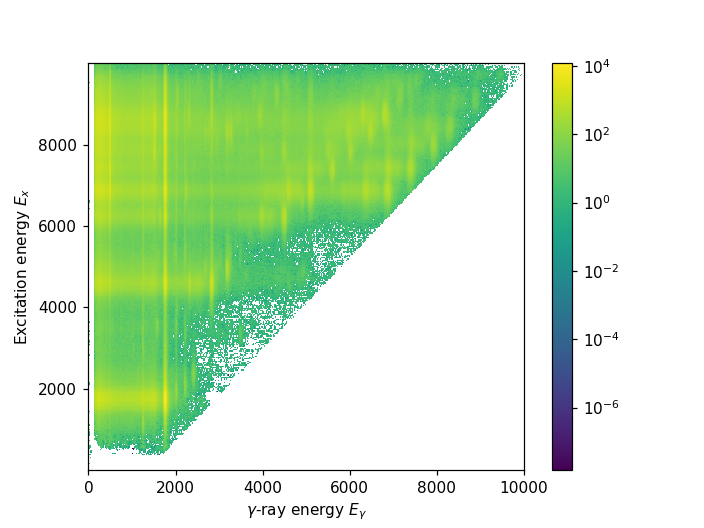

(322, 500)
1203698.3993810248


In [2]:
%matplotlib notebook

# Reading the data 
raw = om.Matrix(path="/home/vala/Downloads/h_Ex_Eg_improved_bgsubtr_noneg_28Si.m")

#Setting every count below this diagonal to zero
raw.cut_diagonal(E1=(1800, 500), E2=(10500, 10000))

#Cutting the matrix itself
raw.cut('Ex',0, 10000)
raw.cut('Eg', 0, 10000)
raw.rebin(axis= "Eg", factor=4)

raw.plot()

print(raw.shape)

#Projecting the first excited state to the Eg axis
raw_py, E = raw.projection(axis="Eg", Emin=1400, Emax=2200)

Eg = raw.Eg

print(np.sum(raw_py))


<IPython.core.display.Javascript object>


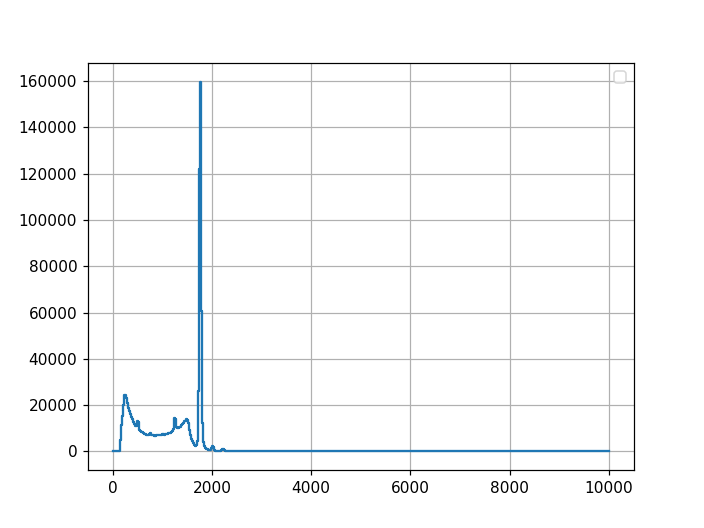

No handles with labels found to put in legend.


In [4]:
%matplotlib notebook

#Plotting the projected raw spectrum 
plt.plot(Eg, raw_py, ls='steps')
plt.legend()
plt.grid()
plt.show()


In [6]:
# Cutting out the zeros from the projected raw spectrum 

thres = 7 #bin number 7 -> Eg = 140 keV 

print(Eg[7])
print(Eg[163])
lst = np.where(raw_py==0)
raw_bay = raw_py[thres:163] #bin number 163 -> Eg = 3266 keV 
energy = Eg[thres:163]

print(len(raw_bay))


140.28056112224448
3266.5330661322646
156


<IPython.core.display.Javascript object>


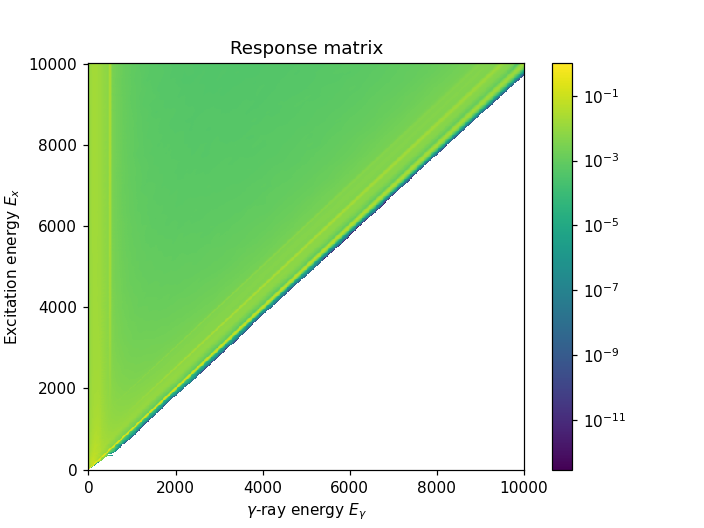

(<matplotlib.collections.QuadMesh at 0x7f986439ba90>,
 <Figure size 640x480 with 2 Axes>)

In [7]:
%matplotlib notebook
# Initiating the response matrix for the Iterative Unfolding OMpy

# Experimental relative FWHM at 1.33 MeV of resulting array
fwhm_abs = 30 # (30/1330 = 2.25% )

folderpath = "/home/vala/Documents/Master/MachineLearning/ompy/OCL_response_functions/oscar2017_scale1.15"
response = om.Response(folderpath)

R_ompy_view, R_tab_view = response.interpolate(Eg, fwhm_abs=fwhm_abs, return_table=True)

# Magne recommends 1/10 of the actual resolution for unfolding purposes
R_ompy_unf, R_tab_unf = response.interpolate(Eg, fwhm_abs=fwhm_abs/10, return_table=True)

R_ompy_view.plot(title="Response matrix", scale='log')

In [8]:
resp_OMpy = R_ompy_view.values  
print(resp_OMpy.shape)

(500, 500)


In [9]:

#Making a matrix out of the raw spectrum, needed for unfolding using OMpy 
raw_dummy = np.array([raw_py, raw_py])
#print(np.sum(raw_dummy[0,:]))
raw_dummy = om.Matrix(raw_dummy, Eg=Eg, Ex=np.array([20, 40]))
raw_dummy.verify_integrity()
raw_dummy.remove_negative()

# Unfolding using OMpy 
unfolder= om.Unfolder(response=R_ompy_unf)
unfolder.response_tab = R_tab_view 
unfolder.use_compton_subtraction = True 
unfolder.num_iter = 500

# Magne suggests some "tweaks" for a better unfolding performance. Default is 1 for all.
unfolder.FWHM_tweak_multiplier = {"fe": 1., "se": 1.1,
                                     "de": 1.3, "511": 0.9}
unfolded_OMpy = unfolder(raw_dummy)

#Getting the spectrum back to 1D 
unfolded_OMpy = unfolded_OMpy[0,:]

folded_OMpy = unfolded_OMpy@resp_OMpy

#checking the sum
print(np.sum(unfolded_OMpy))

1611819.3711828047


<IPython.core.display.Javascript object>


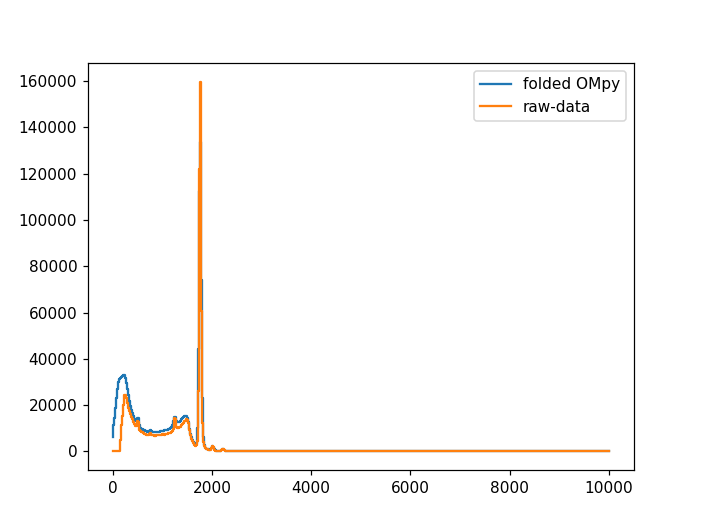

1203698.3993810248
1611819.3711828042


In [11]:
%matplotlib notebook

#Plotting the folded of OMpy to check that everything looks okay

plt.plot(Eg,folded_OMpy, ls='steps', label="folded OMpy")
plt.plot(Eg,raw_py, ls='steps', label="raw-data")
plt.legend()
plt.show()
print(np.sum(raw_py))
print(np.sum(folded_OMpy))

<IPython.core.display.Javascript object>


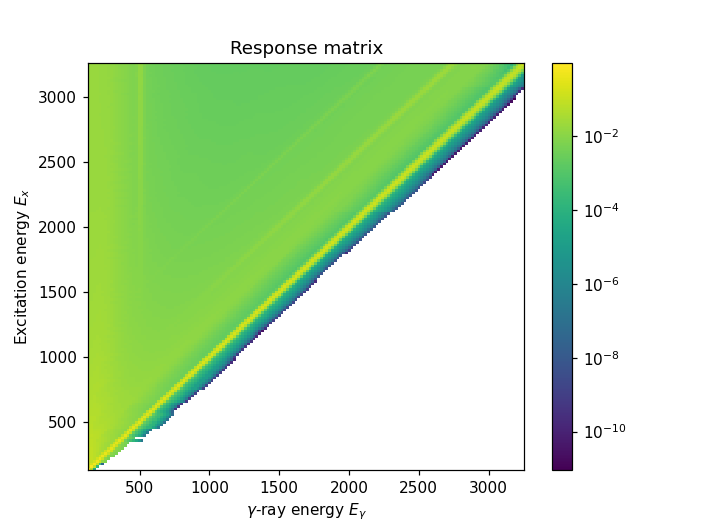

(<matplotlib.collections.QuadMesh at 0x7f9869b41b90>,
 <Figure size 640x480 with 2 Axes>)

In [12]:
#Initiating the matrix for usage in FBU. Using the cut energy instead of Eg

fwhm_abs = 30.0
folderpath = "/home/vala/Documents/Master/MachineLearning/ompy/OCL_response_functions/oscar2017_scale1.15"
response = om.Response(folderpath)

R_bay, R_tab_bay = response.interpolate(energy, fwhm_abs=fwhm_abs, return_table=True)
R_bay_unf, R_tab_bay_unf = response.interpolate(energy, fwhm_abs=fwhm_abs/10, return_table=True)

R_bay.plot(title="Response matrix", scale='log')

[0.58696583 0.58595381 0.58494178 0.58392976 0.58291774 0.58190571
 0.58089369 0.57988166 0.57886964 0.57785762 0.57684559 0.57583357
 0.57482154 0.57377345 0.57185962 0.56994579 0.56803196 0.56611814
 0.56420431 0.56229048 0.56037665 0.55846283 0.556549   0.55464299
 0.55285942 0.55107585 0.54929228 0.54750872 0.54572515 0.54394158
 0.54215802 0.54037445 0.53859088 0.53682295 0.53523477 0.53364659
 0.53205842 0.53047024 0.52888206 0.52729389 0.52570571 0.52411754
 0.52252936 0.52095772 0.51953487 0.51811202 0.51668918 0.51526633
 0.51384349 0.51242064 0.5109978  0.50957495 0.5081521  0.50677519
 0.50573511 0.50469503 0.50365495 0.50261487 0.50157479 0.50053471
 0.49949463 0.49845455 0.49741447 0.49638056 0.49538457 0.49438858
 0.49339259 0.49239659 0.4914006  0.49040461 0.48940862 0.48841263
 0.48741663 0.48646345 0.48573499 0.48500653 0.48427808 0.48354962
 0.48282116 0.48209271 0.48136425 0.48063579 0.47990733 0.47921206
 0.47866798 0.47812389 0.4775798  0.47703571 0.47649162 0.4759

<IPython.core.display.Javascript object>


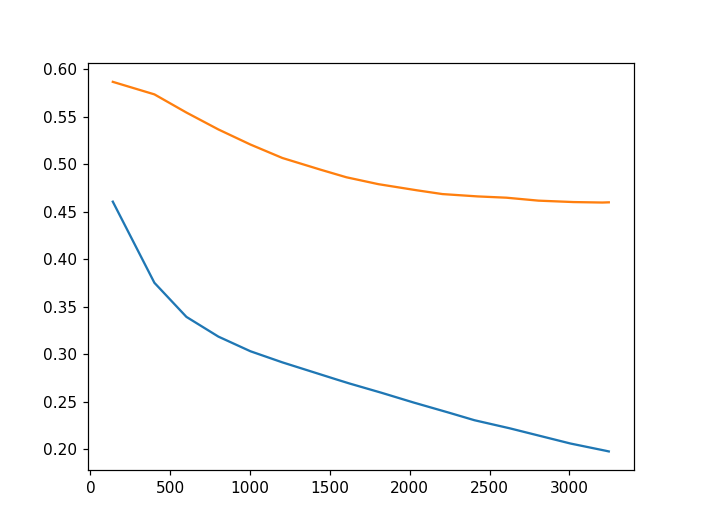

In [13]:
%matplotlib notebook

#Scaling the response with efficiency: 

#Efficency is normalized to 1 for energy 1332 keV, but in this thesis the actual total efficency was calculated
#as 0.5, see chapter 5 in thesis for explanation: 
eff =0.5*R_tab_bay["eff_tot"].values

#The scale of the full energy peak 
pFE = R_tab_bay['pFE'].values

resp =R_bay.values*eff[:,np.newaxis] 

# A check to see if the response matrix now sums up to the total efficiency 
print(np.sum(resp, axis=1))

plt.plot(energy, pFE)
plt.plot(energy, np.sum(resp, axis=1))
plt.show()

<IPython.core.display.Javascript object>


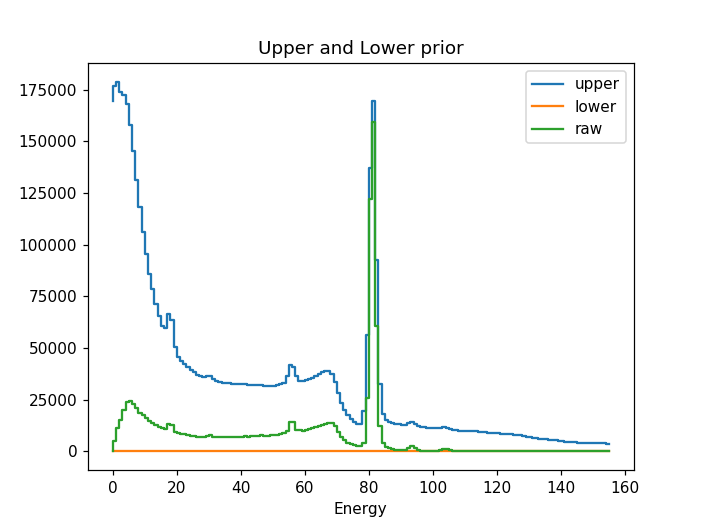

In [14]:
%matplotlib notebook

#Initiating the prior bounds, prior_l = lower, prior_u = upper

prior_l = np.zeros(len(raw_bay))
prior_u = raw_bay/(eff*pFE) #Scaling the upper bounds with the efficiency and scale of full energy peak

#Adding a constant to the bins containing the $1779$ keV energy peak
prior_u[81] += 30000  
prior_u[82] += 250000
prior_u[85:] +=40000

# Looking at the folded of the upper bound to see that it contains all the counts of the raw spectrum
plt.plot(prior_u@resp,ls='steps',markersize=2, label = 'upper')
plt.plot(prior_l@resp, ls='steps', label = 'lower')
plt.plot(raw_bay, ls='steps', label= 'raw')
plt.title('Upper and Lower prior')
plt.xlabel('Energy')
plt.legend()
plt.show()              

In [16]:
# Checking if the response and the raw spectrum has the same lenghts  
print(len(resp))
print(len(raw_bay))

156
156


In [17]:
# Initiating FBU:
myfbu = fbu.PyFBU()

In [19]:
# response of FBU 
myfbu.response = resp
print(myfbu.response.shape)

(156, 156)


<IPython.core.display.Javascript object>


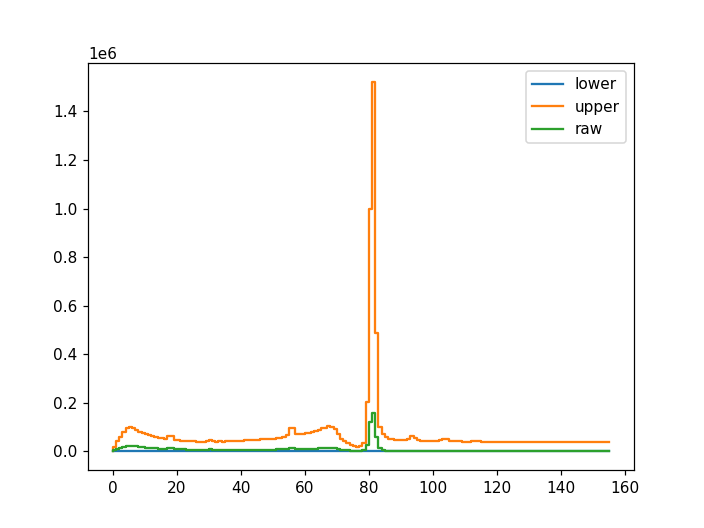

In [20]:
%matplotlib notebook
# Priors: 
myfbu.data =raw_bay
myfbu.prior = 'Uniform'
myfbu.upper = prior_u   
myfbu.lower = prior_l

plt.plot(myfbu.lower, ls='steps',label='lower')
plt.plot(myfbu.upper,ls='steps', label='upper')
plt.plot(myfbu.data,ls='steps', label='raw')
plt.legend()
plt.show()


In [41]:
#Sampling and tuning steps initiated:
myfbu.nTune = 1000
myfbu.nMCMC = 5000

In [42]:
#Running the FBU 
myfbu.run()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


None


Sequential sampling (2 chains in 1 job)
NUTS: [truth155, truth154, truth153, truth152, truth151, truth150, truth149, truth148, truth147, truth146, truth145, truth144, truth143, truth142, truth141, truth140, truth139, truth138, truth137, truth136, truth135, truth134, truth133, truth132, truth131, truth130, truth129, truth128, truth127, truth126, truth125, truth124, truth123, truth122, truth121, truth120, truth119, truth118, truth117, truth116, truth115, truth114, truth113, truth112, truth111, truth110, truth109, truth108, truth107, truth106, truth105, truth104, truth103, truth102, truth101, truth100, truth99, truth98, truth97, truth96, truth95, truth94, truth93, truth92, truth91, truth90, truth89, truth88, truth87, truth86, truth85, truth84, truth83, truth82, truth81, truth80, truth79, truth78, truth77, truth76, truth75, truth74, truth73, truth72, truth71, truth70, truth69, truth68, truth67, truth66, truth65, truth64, truth63, truth62, truth61, truth60, truth59, truth58, truth57, truth5

Elapsed 0:25:35 (7.81 samples/second)


In [43]:
#Trace containing all the posteriors.
#Retrieves the N-dimensional posterior distribution in the form of a list of N arrays.
trace = myfbu.trace

<IPython.core.display.Javascript object>


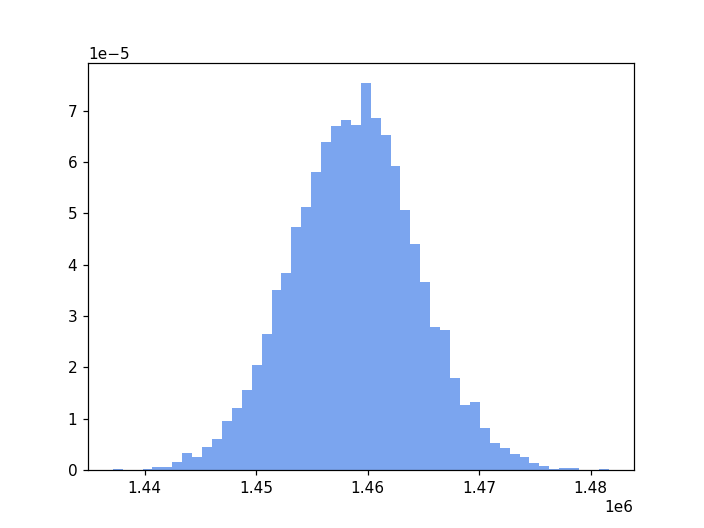

In [44]:
%matplotlib notebook
#Looking at the posterior for one truth-bin, Eg=1778 keV in this case. 
from matplotlib import pyplot as plt
n, bins,_ =plt.hist(trace[82],
         bins=50,alpha=0.85,
         density=True, color = 'cornflowerblue')

plt.ylabel('probability')
plt.show()

In [46]:
from scipy import stats

#Using the function stats.bayes_mvs to estimate the mean, standard deviation and variance of the posteriors
#For more information on the function see:
#T.E. Oliphant, “A Bayesian perspective on estimating mean, variance, and standard-deviation from data”, https://scholarsarchive.byu.edu/facpub/278, 2006.
# and: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bayes_mvs.html

mu = np.zeros(len(trace))
std = np.zeros(len(trace))
var = np.zeros(len(trace))

mu_cred = np.zeros((len(trace),2))
std_cred = np.zeros((len(trace),2))
var_cred = np.zeros((len(trace),2))
for i in range(len(trace)):
    temp ,temp1, temp2 = stats.bayes_mvs(trace[i], alpha=0.68)
    
    mu[i] = temp[0]
    var[i] = temp1[0]
    std[i] = temp2[0]
    
    mu_cred[i, :] = temp[1]
    var_cred[i, :] = temp1[1]
    std_cred[i, :] = temp2[1]
    
    

<IPython.core.display.Javascript object>


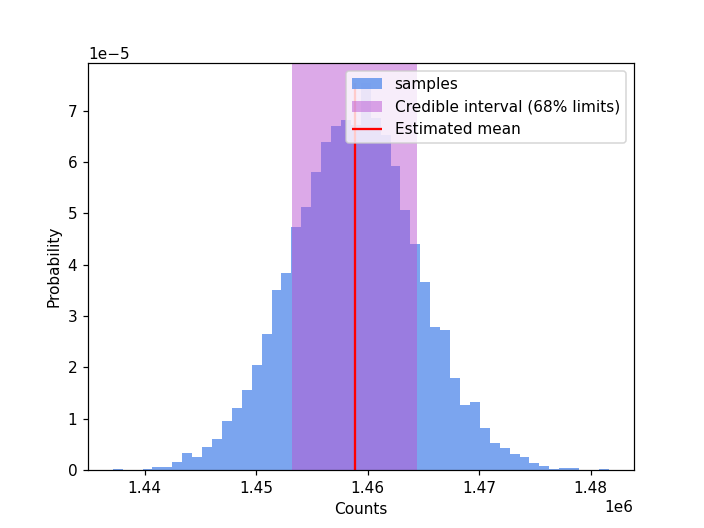

1458822.838792939


In [48]:
%matplotlib notebook

# Figure showing the 68 % interval using the standard deviation of truthbin 82, corresponding to energy = 1778 keV
# and with the estimated mean included

fig, ax = plt.subplots()
choice = 82
n, bins,_ = ax.hist(trace[choice],
bins=50, density=True,alpha=0.85, color = 'cornflowerblue', label='samples')
height = np.max(n)
    
ax.vlines(mu[choice], 0, height, colors='r', label='Estimated mean')
ax.axvspan((mu[choice] -std[choice]), (mu[choice] +std[choice]), facecolor='mediumorchid', alpha=0.5, label=r'Credible interval (68% limits)')
    
    
plt.xlabel('Counts')
plt.ylabel('Probability')
plt.legend()

plt.show()
print(mu[choice])

In [49]:
# Estimating the median of the posteriors and the credible interval including the median
# using the function sp.stats.t.interval (see scipy webpages for more information).

credible_level = 0.68
degrees_freedom = len(trace) - 1
median = np.zeros(len(trace))
std_median= np.zeros(len(trace))
cred_int_median = np.zeros((len(trace), 2))
for i in range(len(trace)):
    median[i] = np.median(trace[i])
    std_median[i] = sp.stats.median_absolute_deviation(trace[i])
    cred_int_median[i, :] = sp.stats.t.interval(credible_level, median[i], std_median[i])


<IPython.core.display.Javascript object>


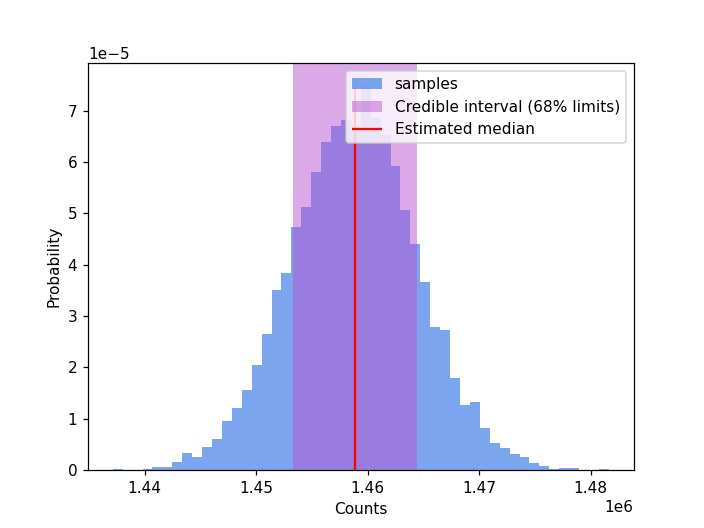

1458848.6911944128


In [51]:
%matplotlib notebook
# Figure showing the 68 % interval using the credible interval of the median of truthbin 82, 
#corresponding to energy = 1778 keV

fig, ax = plt.subplots()
choice = 82
n, bins,_ = ax.hist(trace[choice],
bins=50, density=True,alpha=0.85, color = 'cornflowerblue', label='samples')
height = np.max(n)


ax.vlines(median[choice], 0, height, colors='r', label='Estimated median')
ax.axvspan((median[choice] -cred_int_median[choice,0]), (median[choice] +cred_int_median[choice, 1]), facecolor='mediumorchid', alpha=0.5, label=r'Credible interval (68% limits)')
    
    
plt.xlabel('Counts')
plt.ylabel('Probability')
plt.legend()

plt.show()
print(median[choice])

In [64]:
# Calculating the MAP
myfbu.mode = True
myfbu.run()

None


logp = -55,380, ||grad|| = 0.7071: 100%|██████████| 622/622 [00:01<00:00, 332.78it/s]  


{'truth0_interval__': array(-13.31893028), 'truth1_interval__': array(-16.42133349), 'truth2_interval__': array(-16.86321802), 'truth3_interval__': array(-16.81781047), 'truth4_interval__': array(-17.38040552), 'truth5_interval__': array(-18.79658115), 'truth6_interval__': array(-18.66802013), 'truth7_interval__': array(-18.03314733), 'truth8_interval__': array(-17.15098503), 'truth9_interval__': array(-16.46039248), 'truth10_interval__': array(-16.13579864), 'truth11_interval__': array(-15.91851478), 'truth12_interval__': array(-15.80445261), 'truth13_interval__': array(-15.78634697), 'truth14_interval__': array(-15.75390415), 'truth15_interval__': array(-15.72879207), 'truth16_interval__': array(-15.68090789), 'truth17_interval__': array(-15.60067235), 'truth18_interval__': array(-15.23597709), 'truth19_interval__': array(-15.25579822), 'truth20_interval__': array(-15.47523186), 'truth21_interval__': array(-15.41658841), 'truth22_interval__': array(-15.40282068), 'truth23_interval__'

In [65]:
# The MAP of FBU contains the log of the estimated spectrum first and then the linear.
myfbu.MAP

{'truth0_interval__': array(-13.31893028),
 'truth1_interval__': array(-16.42133349),
 'truth2_interval__': array(-16.86321802),
 'truth3_interval__': array(-16.81781047),
 'truth4_interval__': array(-17.38040552),
 'truth5_interval__': array(-18.79658115),
 'truth6_interval__': array(-18.66802013),
 'truth7_interval__': array(-18.03314733),
 'truth8_interval__': array(-17.15098503),
 'truth9_interval__': array(-16.46039248),
 'truth10_interval__': array(-16.13579864),
 'truth11_interval__': array(-15.91851478),
 'truth12_interval__': array(-15.80445261),
 'truth13_interval__': array(-15.78634697),
 'truth14_interval__': array(-15.75390415),
 'truth15_interval__': array(-15.72879207),
 'truth16_interval__': array(-15.68090789),
 'truth17_interval__': array(-15.60067235),
 'truth18_interval__': array(-15.23597709),
 'truth19_interval__': array(-15.25579822),
 'truth20_interval__': array(-15.47523186),
 'truth21_interval__': array(-15.41658841),
 'truth22_interval__': array(-15.40282068)

In [66]:
# Maiking MAP into an array: 
MAP = np.zeros(len(myfbu.MAP)) 
for bin, (name,m) in enumerate(myfbu.MAP.items()):
    #print(m)
    MAP[bin] = m
    
print(len(MAP)) 

312


<IPython.core.display.Javascript object>


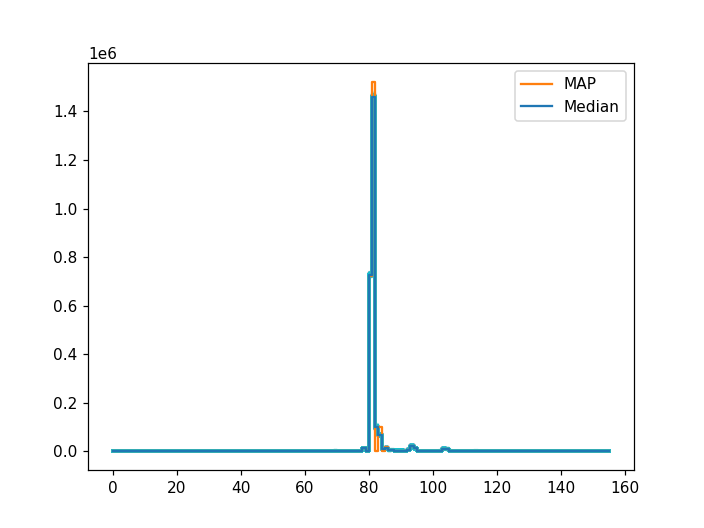

In [124]:
%matplotlib notebook

#The MAP of the posteriors plotted together with the samples: 

#Picking out 500 samples randomly from each bin and plotting them together with the MAP and Median:
inds = np.random.randint(len(trace[0]), size=500)
for ind in inds:
    sample = np.zeros(len(trace))
    for i in range(len(trace)):
        sample[i] = trace[i][ind]
    
    plt.plot( sample, "C9", ls='steps', alpha=0.2)
plt.plot( MAP[156:], "C1", ls='steps',alpha = 1, label = 'MAP')
plt.plot( median, "C0", ls='steps', alpha = 1, label = 'Median')
#plt.yscale('log')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


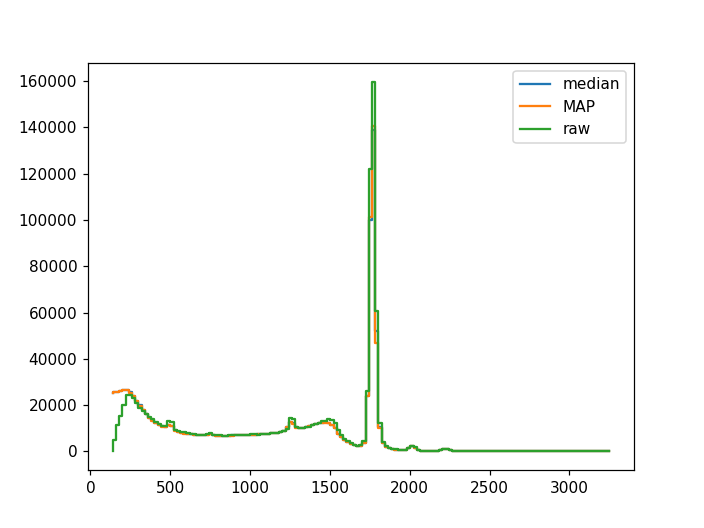

In [127]:
%matplotlib notebook

# Folded of MAP and median:
plt.plot(energy, median@resp, ls='steps', alpha = 1, label = 'median')
plt.plot(energy, MAP[156:]@resp, ls='steps', alpha = 1, label = 'MAP')
plt.plot(energy, raw_bay, ls='steps', label='raw')

#plt.yscale('log')
plt.legend()
plt.show()

In [69]:
#Estimating a HPD credible interval of the posteriors: 

hpd = np.zeros((len(trace),2))
for i in range(len(trace)):
    hpd[i:] = mc.stats.hpd(trace[i], credible_interval=0.68)
    
#print(hpd)    

In [118]:
from os import path
%matplotlib inline 

#Saving all posteriors presented in histograms 
outpath = 'figures_28Si_1st_Ex-energy'

for i in range(len(trace)):
    fig, ax = plt.subplots(figsize=(10,6))
    n, bins,_ = ax.hist(trace[i],
    bins=50, density=True,alpha=0.85, color = 'cornflowerblue', label='samples')
    plt.xlabel('Counts')
    plt.ylabel('Probability')
    plt.legend()
    plt.savefig(path.join(outpath, 'truth {0}.png'.format(i)))
    plt.close()

In [70]:
# Saving all the posteriors to csv file:
cols = []
for i in range(len(trace)):
    name = 'truth%d'%i
    
    cols.append(name)

df = pd.DataFrame(dict(zip(cols, trace)))

df.to_csv('unfolding_Si28_samples_1stEx_030720.csv', index=False)

In [75]:
# Saving all estimated values to csv file 
df = pd.DataFrame({ 'Energy': energy,
                    'est. mean': mu,
                    'est. std': std,
                    'est var': var,
                    'est median': median, 
                    'est MAP': MAP[156:], 
                    'cred mu min': mu_cred[:, 0],   
                    'cred mu max': mu_cred[:, 1],
                    'cred std min': std_cred[:, 0],   
                    'cred std max': std_cred[:, 1],
                    'cred var min': var_cred[:, 0],   
                    'cred var max': var_cred[:, 1],
                    'cred median min': cred_int_median[:,0],
                    'cred median max': cred_int_median[:,1],
                    'HPD min': hpd[:,0],
                    'HPD max': hpd[:,1] 
                  })

df.to_csv('unfolding_Si28_credint_68_030720.csv', index=False)